In [1]:
#CV

In [2]:
#图像增广
%matplotlib inline
import d2lzh as d2l
import mxnet as mx
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, utils as gutils
import sys
import time

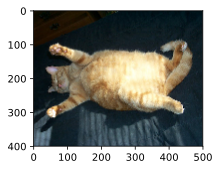

In [3]:
d2l.set_figsize()
img = image.imread('./img/cat1.jpg')
d2l.plt.imshow(img.asnumpy())


In [4]:
# 绘图函数
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [11]:
def apply(img,aug,num_rows=2,num_cols=4,scale =1.5):
    Y = [aug(img) for _ in range(num_rows*num_cols)]
    show_images(Y,num_rows,num_cols,scale)

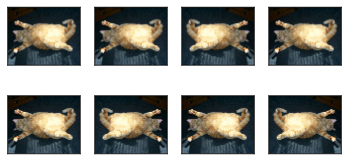

In [12]:
#随机左右翻转
apply(img,gdata.vision.transforms.RandomFlipLeftRight())

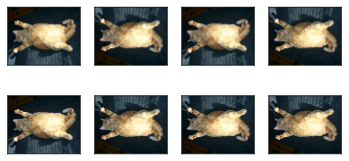

In [14]:
#随机上下翻转
apply(img,gdata.vision.transforms.RandomFlipTopBottom())

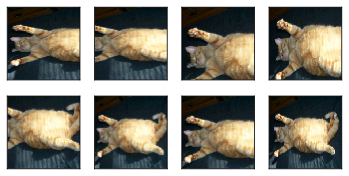

In [19]:
#随机剪裁（并自动放大到原图像尺寸）
shape_aug = gdata.vision.transforms.RandomResizedCrop((200,200),scale=(0.1,1),ratio=(0.5,2))
apply(img,shape_aug)

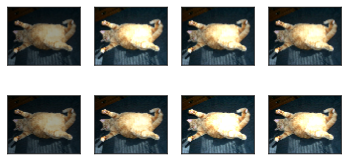

In [21]:
#亮度
apply(img, gdata.vision.transforms.RandomBrightness(0.5))

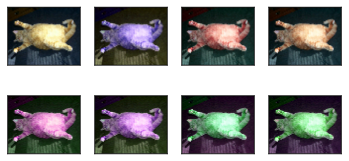

In [23]:
#色调
apply(img, gdata.vision.transforms.RandomHue(0.5))

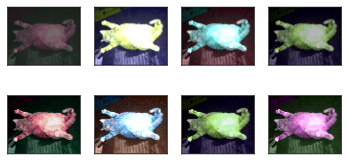

In [24]:
#分别改变亮度，对比度，饱和度，色调
color_aug = gdata.vision.transforms.RandomColorJitter(
                brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

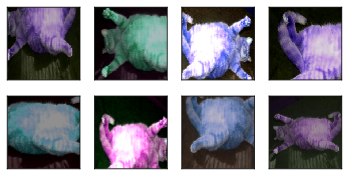

In [25]:
#使用Compose实例实现多个图像增广方法的叠加
augs =  gdata.vision.transforms.Compose([
                            gdata.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img,augs)

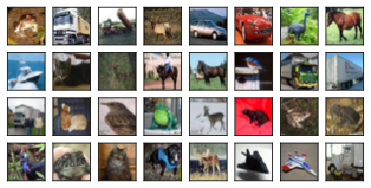

In [38]:
show_images(gdata.vision.CIFAR10(train=True)[0:32][0], 4, 8, scale=0.8);


In [39]:
flip_aug = gdata.vision.transforms.Compose([    #对训练集进行增广
        gdata.vision.transforms.RandomFlipLeftRight(),
        gdata.vision.transforms.ToTensor()])

no_aug = gdata.vision.transforms.Compose([      #不对测试集进行增广
        gdata.vision.transforms.ToTensor()])


In [40]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size):
    return gdata.DataLoader(
        gdata.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

In [48]:
def try_all_gpus(): # 本函数已保存在d2lzh包中⽅便以后使⽤
    ctxes = []
    try:
        for i in range(16): # 假设⼀台机器上GPU的数量不超过16
            ctx = mx.gpu(i)
            _ = nd.array([0], ctx=ctx)
            ctxes.append(ctx)
    except mx.base.MXNetError:
        pass
    if not ctxes:
        ctxes = [mx.cpu()]
    return ctxes

In [49]:
def _get_batch(batch, ctx):
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
        gutils.split_and_load(labels, ctx), features.shape[0])

In [42]:
# 正确率评价函数
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    if isinstance(ctx, mx.Context): #采取多GPU运算
        ctx = [ctx]
    acc_sum, n = nd.array([0]), 0
    for batch in data_iter:
        features, labels, _ = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            y = y.astype('float32')
            acc_sum += (net(X).argmax(axis=1) == y).sum().copyto(mx.cpu())
            n += y.size
        acc_sum.wait_to_read()
    return acc_sum.asscalar() / n


In [43]:
def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                    for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
    test_acc = evaluate_accuracy(test_iter, net, ctx)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
            'time %.1f sec'
            % (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc,
            time.time() - start))

In [44]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, ctx, net = 256, try_all_gpus(), d2l.resnet18(10)
    net.initialize(ctx=ctx, init=init.Xavier())
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    loss = gloss.SoftmaxCrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=10)

In [50]:
train_with_data_aug(flip_aug,no_aug)

training on [gpu(0)]


KeyboardInterrupt: 

In [51]:
#迁移学习 微调
%matplotlib inline
import d2lzh as d2l
from mxnet import gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo
from mxnet.gluon import utils as gutils
import os
import zipfile

#获取数据
data_dir = './data'
base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
fname = gutils.download(
        base_url + 'gluon/dataset/hotdog.zip',
        path=data_dir, sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5')
with zipfile.ZipFile(fname, 'r') as z:
    z.extractall(data_dir)

In [52]:
#加载数据集
train_imgs = gdata.vision.ImageFolderDataset(
    os.path.join(data_dir, 'hotdog/train'))
test_imgs = gdata.vision.ImageFolderDataset(
    os.path.join(data_dir, 'hotdog/test'))


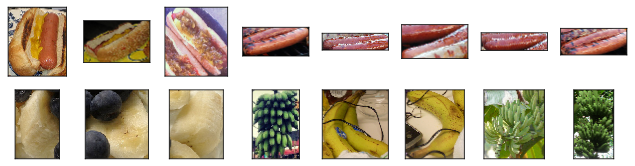

In [53]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);


In [56]:
# 指定RGB三个通道的均值和⽅差来将图像通道归⼀化
normalize = gdata.vision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomResizedCrop(224),
    gdata.vision.transforms.RandomFlipLeftRight(),
    gdata.vision.transforms.ToTensor(),
    normalize])
test_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.Resize(256),
    gdata.vision.transforms.CenterCrop(224),
    gdata.vision.transforms.ToTensor(),
    normalize])

In [55]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)

In [57]:
pretrained_net.output

Dense(512 -> 1000, linear)

In [58]:
finetune_net = model_zoo.vision.resnet18_v2(classes=2)  #修改输出层输出2分类
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier())
# output中的模型参数将在迭代中使⽤10倍⼤的学习率
finetune_net.output.collect_params().setattr('lr_mult', 10)

In [59]:
finetune_net.output   #更改预训练模型的输出层来匹配问题

Dense(512 -> 2, linear)

In [64]:
def train_fine_tuning(net, learning_rate, batch_size=1, num_epochs=5):
    train_iter = gdata.DataLoader(
        train_imgs.transform_first(train_augs), batch_size, shuffle=True)
    test_iter = gdata.DataLoader(
        test_imgs.transform_first(test_augs), batch_size)
    ctx = d2l.try_all_gpus()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gloss.SoftmaxCrossEntropyLoss()    #损失函数
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': 0.001})
    d2l.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)


In [65]:
train_fine_tuning(finetune_net, 0.01)

training on [gpu(0)]


MXNetError: [22:55:56] c:\jenkins\workspace\mxnet-tag\mxnet\src\operator\tensor\../mxnet_op.h:794: Check failed: err == cudaSuccess (2 vs. 0) : Name: mxnet_generic_kernel ErrStr:out of memory

In [1]:
#标记框
%matplotlib inline
import d2lzh as d2l
from mxnet import image


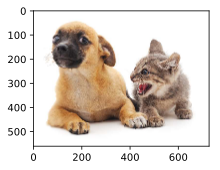

In [3]:
d2l.set_figsize()
img = image.imread('./img/catdog.jpg').asnumpy()
d2l.plt.imshow(img) # 加分号只显⽰图

In [8]:
dog_bbox,cat_bbox = [60,45,378,516],[400,112,655,493]

def bbox_to_rect(bbox,color): # 本函数已保存在d2lzh包中⽅便以后使⽤
# 将边界框(左上x, 左上y, 右下x, 右下y)格式转换成matplotlib格式
# ((左上x, 左上y), 宽, ⾼)
    return d2l.plt.Rectangle(xy=(bbox[0],bbox[1]),width=bbox[2]-bbox[0], height = bbox[3]-bbox[1],
                          fill = False,edgecolor = color,linewidth = 2)
    

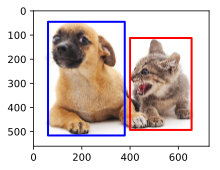

In [10]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox,'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox,'red'))

In [11]:
#锚框
%matplotlib inline
import d2lzh as d2l
from mxnet import contrib, gluon, image, nd
import numpy as np
np.set_printoptions(2)


In [13]:
#生成锚框
img = image.imread('./img/catdog.jpg').asnumpy()
h, w = img.shape[0:2]
print(h, w)
X = nd.random.uniform(shape=(1, 3, h, w)) # 构造输⼊数据
Y = contrib.nd.MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


(1, 2042040, 4)

In [14]:
boxes = Y.reshape((h, w, 5, 4))
boxes[250, 250, 0, :]


[0.06 0.07 0.63 0.82]
<NDArray 4 @cpu(0)>

In [15]:
 # 多锚框生成
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)   #标签
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):  #生成锚框
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.asnumpy(), color)
        axes.add_patch(rect)            #添加锚框
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))


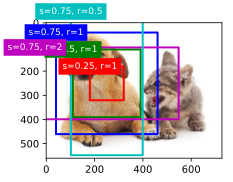

In [17]:
d2l.set_figsize()
bbox_scale = nd.array((w,h,w,h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes,boxes[250,250,:,:] * bbox_scale,['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
's=0.75, r=0.5'])

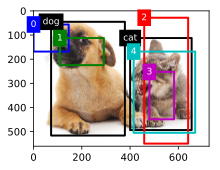

In [18]:
ground_truth = nd.array([[0, 0.1, 0.08, 0.52, 0.92],
    [1, 0.55, 0.2, 0.9, 0.88]])
anchors = nd.array([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
    [0.57, 0.3, 0.92, 0.9]])
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [19]:
#锚框标注类别和偏移量
labels = contrib.nd.MultiBoxTarget(anchors.expand_dims(axis=0),
                                    ground_truth.expand_dims(axis=0),
                                    nd.zeros((1, 3, 5)))


In [21]:
labels[2]


[[0. 1. 2. 0. 2.]]
<NDArray 1x5 @cpu(0)>

In [22]:
anchors = nd.array([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = nd.array([0] * anchors.size)
cls_probs = nd.array([[0] * 4, # 背景的预测概率
        [0.9, 0.8, 0.7, 0.1], # 狗的预测概率
        [0.1, 0.2, 0.3, 0.9]]) # 猫的预测概率

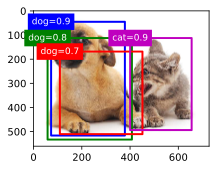

In [24]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
    ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [25]:
#非极大抑制删除重复框
output = contrib.ndarray.MultiBoxDetection(
        cls_probs.expand_dims(axis=0), offset_preds.expand_dims(axis=0),
        anchors.expand_dims(axis=0), nms_threshold=0.5)

output


[[[ 0.    0.9   0.1   0.08  0.52  0.92]
  [ 1.    0.9   0.55  0.2   0.9   0.88]
  [-1.    0.8   0.08  0.2   0.56  0.95]
  [-1.    0.7   0.15  0.3   0.62  0.91]]]
<NDArray 1x4x6 @cpu(0)>

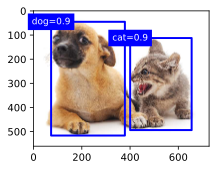

In [26]:
fig = d2l.plt.imshow(img)
for i in output[0].asnumpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [nd.array(i[2:]) * bbox_scale], label)


In [27]:
#多尺度目标检测

In [28]:
%matplotlib inline
import d2lzh as d2l
from mxnet import contrib, image, nd
img = image.imread('./img/catdog.jpg')
h, w = img.shape[0:2]
h, w

(561, 728)

In [29]:
d2l.set_figsize()
#显示多锚框
def display_anchors(fmap_w, fmap_h, s):
    fmap = nd.zeros((1, 10, fmap_w, fmap_h)) # 前两维的取值不影响输出结果
    anchors = contrib.nd.MultiBoxPrior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = nd.array((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img.asnumpy()).axes,
                anchors[0] * bbox_scale)

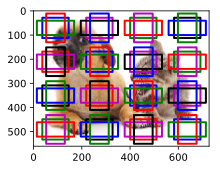

In [30]:
 display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

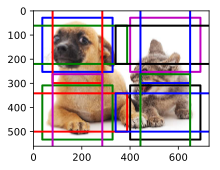

In [32]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

In [33]:
 %matplotlib inline
import d2lzh as d2l
from mxnet import gluon, image
from mxnet.gluon import utils as gutils
import os
def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
        'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
        'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
        'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)


In [36]:
# 加载数据集
def load_data_pikachu(batch_size, edge_size=256): # edge_size：输出图像的宽和⾼
    data_dir = './data/pikachu'
    _download_pikachu(data_dir)
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), # 输出图像的形状
        shuffle=True, # 以随机顺序读取数据集
        rand_crop=1, # 随机裁剪的概率为1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter,val_iter


In [37]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size)
batch = train_iter.next()
batch.data[0].shape, batch.label[0].shape


((32, 3, 256, 256), (32, 1, 5))

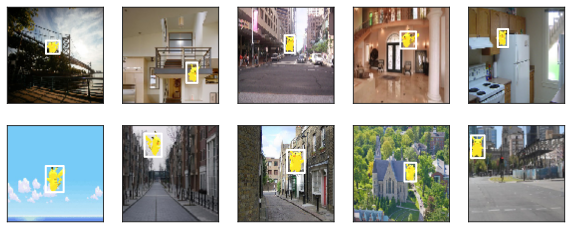

In [38]:
imgs = (batch.data[0][0:10].transpose((0, 2, 3, 1))) / 255
axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, label in zip(axes, batch.label[0][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])


In [2]:
#单发多框检测SSD

%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, contrib, gluon, image, init, nd
from mxnet.gluon import loss as gloss, nn
import time

In [40]:
#类别预测层 保持图像高和宽 让后面的检测框能够正确锚定
#输出每个锚框的n+1个类别
def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3,
        padding=1)

In [41]:
#边界预测层
#输出每个锚框预测4个偏移量
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)

In [42]:
#前向运算
def forward(x, block):
    block.initialize()
    return block(x)
Y1 = forward(nd.zeros((2, 8, 20, 20)), cls_predictor(5, 10))
Y2 = forward(nd.zeros((2, 16, 10, 10)), cls_predictor(3, 10))
(Y1.shape, Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

In [43]:
#预测结果维度变换
def flatten_pred(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()
def concat_preds(preds):
    return nd.concat(*[flatten_pred(p) for p in preds], dim=1)

In [44]:
concat_preds([Y1, Y2]).shape

(2, 25300)

In [48]:
#高宽减半块  让输出特征图中每个单元的感受野更广阔
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
                nn.BatchNorm(in_channels=num_channels),
                nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

forward(nd.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape


(2, 10, 10, 10)

In [49]:
#基础网络块
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk
forward(nd.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

In [50]:
#单发多框检测模型⼀共包含5个模块，每个模块输出的特征图既⽤来⽣成锚框，⼜⽤来预测这些
#锚框的类别和偏移量。第⼀模块为基础⽹络块，第⼆模块⾄第四模块为⾼和宽减半块，第五模块
#使⽤全局最⼤池化层将⾼和宽降到1。因此第⼆模块⾄第五模块均为多尺度特征块。
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

In [53]:
#这⾥不仅返回卷积计算输出的特征图Y，还返回根据Y⽣成的当前尺度的锚框，
#以及基于Y预测的锚框类别和偏移量。

def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = contrib.ndarray.MultiBoxPrior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)


In [54]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
[0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [61]:
#模型
class TinySSD(nn.Block):
    def __init__(self,num_classes,**kwargs):
        super(TinySSD,self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(5):
            setattr(self,'blk_%d'%i,get_blk(i))
            setattr(self,'cls_%d'%i,cls_predictor(num_anchors,num_classes))
            setattr(self,'bbox_%d'%i,bbox_predictor(num_anchors))
    def forward(self,X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):  #前向运算，类型预测和锚框偏移量预测
            X,anchors[i],cls_preds[i],bbox_preds[i] = blk_forward(X,getattr(self, 'blk_%d' % i), sizes[i], ratios[i],
                        getattr(self, 'cls_%d' % i), getattr(self, 'bbox_%d' % i))
        return (nd.concat(*anchors,dim=1),concat_preds(cls_preds).reshape((0, -1, self.num_classes + 1)),
                   concat_preds(bbox_preds))

In [62]:
net = TinySSD(num_classes=1)
net.initialize()
X = nd.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)
print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


In [64]:
batch_size = 32
train_iter, _ = d2l.load_data_pikachu(batch_size)


In [65]:
ctx, net = d2l.try_gpu(), TinySSD(num_classes=1)
net.initialize(init=init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': 0.2, 'wd': 5e-4})


In [66]:
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox

In [67]:
#平均绝对误差评价边界框的预测结果
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后⼀维，argmax需要指定最后⼀维
    return (cls_preds.argmax(axis=-1) == cls_labels).sum().asscalar()
#锚框评价
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().sum().asscalar()

In [70]:
for epoch in range(20):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    train_iter.reset() # 从头读取数据
    start = time.time()
    for batch in train_iter:
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            # ⽣成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)
            # 为每个锚框标注类别和偏移量
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
        # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                            bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size
    if (epoch + 1) % 5 == 0:
        print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
            epoch + 1, 1 - acc_sum / n, mae_sum / m, time.time() - start))

epoch  5, class err 3.14e-03, bbox mae 3.43e-03, time 18.3 sec
epoch 10, class err 3.07e-03, bbox mae 3.23e-03, time 28.2 sec
epoch 15, class err 3.01e-03, bbox mae 3.24e-03, time 21.6 sec
epoch 20, class err 2.82e-03, bbox mae 3.07e-03, time 21.5 sec


In [71]:
img = image.imread('./img/pikachu.jpg')
feature = image.imresize(img, 256, 256).astype('float32')
X = feature.transpose((2, 0, 1)).expand_dims(axis=0)

In [73]:
def predict(X):
    anchors,cls_preds,bbox_preds = net(X.as_in_context(ctx))
    cls_probs = cls_preds.softmax().transpose((0,2,1))
    #非极大抑制
    output = contrib.nd.MultiBoxDetection(cls_probs,bbox_preds,anchors)
    idx = [i for i,row in enumerate(output[0]) if row[0].asscalar()!=-1]
    return output[0,idx]

output = predict(X)

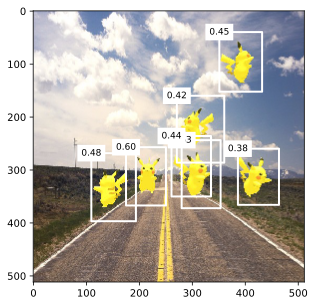

In [74]:
d2l.set_figsize((5, 5))
def display(img, output, threshold):
    fig = d2l.plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output, threshold=0.3)


In [3]:
#语义分割
%matplotlib inline
import d2lzh as d2l
from mxnet import gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo, nn
import os
import sys


In [4]:
#全卷积网络FCN
#转置卷积层
X = nd.arange(1, 17).reshape((1, 1, 4, 4))
K = nd.arange(1, 10).reshape((1, 1, 3, 3))
conv = nn.Conv2D(channels=1, kernel_size=3)
conv.initialize(init.Constant(K))
conv(X), K

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>, 
 [[[[1. 2. 3.]
    [4. 5. 6.]
    [7. 8. 9.]]]]
 <NDArray 1x1x3x3 @cpu(0)>)

In [5]:
#使用预训练的resNet18构建模型
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

num_classes = 21
#添加转置卷积层
net.add(nn.Conv2D(num_classes, kernel_size=1),
        nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16,
        strides=32))


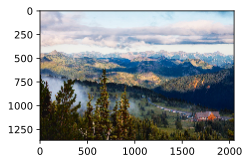

In [6]:
#样式迁移
d2l.set_figsize()
content_img = image.imread('./img/rainier.jpg')
d2l.plt.imshow(content_img.asnumpy());


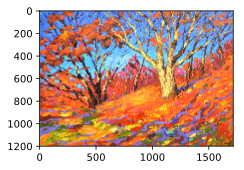

In [7]:
style_img = image.imread('./img/autumn_oak.jpg')
d2l.plt.imshow(style_img.asnumpy());


In [8]:
rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

#图像预处理，RGB通道标准化，
def preprocess(img,image_shape):
    img = image.imresize(img,*image_shape)
    img = (img.astype('float32')/2555-rgb_mean) / rgb_std
    return img.transpose((2,0,1)).expand_dims(axis=0)

#后处理函数postprocess则将输出图像中的像素值还原回标准化之前的值
def postprocess(img):
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1,2,0)) * rgb_std + rgb_mean).clip(0,1)



In [9]:
#使用预训练模型抽取图像特征
pretrained_net = model_zoo.vision.vgg19(pretrained=True)  


In [10]:
#选择作为样式，内容层
style_layers, content_layers = [0, 5, 10, 19, 28], [25]


In [11]:
net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

In [12]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    #逐层计算，得到内容层和样式层的输出
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles


In [13]:
#对内容图像抽取内容特征
def get_contents(image_shape,ctx):
    content_X = preprocess(content_img,image_shape).copyto(ctx)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

#对样式图像抽取样式特征
def get_styles(image_shape,ctx):
    style_X = preprocess(style_img, image_shape).copyto(ctx)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [14]:
#内容损失
def content_loss(Y_hat, Y):
    return (Y_hat - Y).square().mean()


In [15]:
#拉姆矩阵计算样式层输出样式
def gram(X):
    num_channels, n = X.shape[1], X.size // X.shape[1]
    X = X.reshape((num_channels, n))
    return nd.dot(X, X.T) / (num_channels * n)

In [16]:
#样式层损失
def style_loss(Y_hat,gram_Y):
    return (gram(Y_hat)-gram_Y).square().mean()

In [17]:
#总变量损失
def tv_loss(Y_hat):
    return 0.5 * ((Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).abs().mean() +
                    (Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).abs().mean())

In [18]:
#损失函数
content_weight, style_weight, tv_weight = 1, 1e3, 10
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = nd.add_n(*styles_l) + nd.add_n(*contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

In [19]:
#合成图像
class GeneratedImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)
    def forward(self):
        return self.weight.data()


In [20]:
#创建模型实例
def get_inits(X, ctx, lr, styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam',
                            {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [21]:
#训练模型
def train(X, contents_Y, styles_Y, ctx, lr, max_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, ctx, lr, styles_Y)
    for i in range(max_epochs):
        start = time.time()
        with autograd.record():  #分配内存
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)  #计算内容和样式
            #损失计算
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        nd.waitall()
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                    'TV loss %.2f, %.2f sec'
                    % (i, nd.add_n(*contents_l).asscalar(),
                        nd.add_n(*styles_l).asscalar(), tv_l.asscalar(),
                                    time.time() - start))
        if i % lr_decay_epoch == 0 and i != 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
            print('change lr to %.1e' % trainer.learning_rate)
    return X

In [26]:
ctx, image_shape = d2l.try_gpu(), (225, 150)
net.collect_params().reset_ctx(ctx)
content_X, contents_Y = get_contents(image_shape, ctx)
_, styles_Y = get_styles(image_shape, ctx)
output = train(content_X, contents_Y, styles_Y, ctx, 0.01, 500, 200)

epoch  50, content loss 0.58, style loss 0.58, TV loss 0.47, 0.05 sec
epoch 100, content loss 0.44, style loss 0.47, TV loss 0.38, 0.05 sec
epoch 150, content loss 0.40, style loss 0.44, TV loss 0.34, 0.05 sec
epoch 200, content loss 0.38, style loss 0.42, TV loss 0.32, 0.06 sec
change lr to 1.0e-03
epoch 250, content loss 0.36, style loss 0.42, TV loss 0.31, 0.05 sec
epoch 300, content loss 0.36, style loss 0.42, TV loss 0.31, 0.05 sec
epoch 350, content loss 0.36, style loss 0.41, TV loss 0.31, 0.05 sec
epoch 400, content loss 0.36, style loss 0.41, TV loss 0.30, 0.05 sec
change lr to 1.0e-04
epoch 450, content loss 0.35, style loss 0.41, TV loss 0.30, 0.05 sec


In [27]:
d2l.plt.imsave('./img/neural-style-1.png', postprocess(output).asnumpy())